In [1]:
import pandas as pd
import numpy as np
import sys
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import heapq
import itertools
import implicit
import pickle
import time
import operator

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from itertools import chain
from pathlib import Path
from implicit.als import AlternatingLeastSquares
from datetime import datetime
from implicit.nearest_neighbours import tfidf_weight
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix, csr_matrix
from numpy import bincount, log, sqrt

## Load Datasets

In [2]:
df_order_products__prior = pd.read_csv("../data/raw/order_products__prior.csv")
df_order_products__train = pd.read_csv("../data/raw/order_products__train.csv")
df_orders = pd.read_csv("../data/raw/orders.csv") 
df_products = pd.read_csv("../data/raw/products.csv")

## Data Preparation

### User basket products

In [3]:
df_merged_order_products_prior = pd.merge(df_order_products__prior, df_products, on="product_id", how="left")

df_merged_order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [4]:
df_merged_order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 7 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
product_name         object
aisle_id             int64
department_id        int64
dtypes: int64(6), object(1)
memory usage: 1.9+ GB


In [5]:
df_orders_users_train = df_orders.loc[(df_orders.eval_set == "train")].reset_index()
df_orders_users_train.head()

,index,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,10,1187899,1,train,11,4,8,14.0
1,25,1492625,2,train,15,1,11,30.0
2,49,2196797,5,train,5,0,11,6.0
3,74,525192,7,train,21,2,11,6.0
4,78,880375,8,train,4,1,14,10.0


In [6]:
df_orders_users_train.shape

(131209, 8)

In [7]:
df_orders_users_train = df_orders_users_train[["order_id", "user_id"]]
df_orders_users_train.head()

,order_id,user_id
0,1187899,1
1,1492625,2
2,2196797,5
3,525192,7
4,880375,8


In [8]:
df_order_products_test = df_order_products__train[["order_id", "product_id"]]
df_order_products_test.head()

,order_id,product_id
0,1,49302
1,1,11109
2,1,10246
3,1,49683
4,1,43633


In [9]:
df_order_products_test.shape

(1384617, 2)

In [10]:
df_order_products_test = df_order_products_test.groupby("order_id")["product_id"]\
                         .apply(list).reset_index().rename(columns={"product_id": "products"})
    
df_order_products_test.head()

,order_id,products
0,1,"[49302, 11109, 10246, 49683, 43633, 13176, 472..."
1,36,"[39612, 19660, 49235, 43086, 46620, 34497, 486..."
2,38,"[11913, 18159, 4461, 21616, 23622, 32433, 2884..."
3,96,"[20574, 30391, 40706, 25610, 27966, 24489, 39275]"
4,98,"[8859, 19731, 43654, 13176, 4357, 37664, 34065..."


In [11]:
df_order_products_test.shape

(131209, 2)

In [12]:
df_user_products_test = pd.merge(df_orders_users_train, df_order_products_test, on="order_id")
df_user_products_test.head()

,order_id,user_id,products
0,1187899,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,1492625,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,2196797,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."
3,525192,7,"[12053, 47272, 37999, 13198, 43967, 40852, 176..."
4,880375,8,"[15937, 5539, 10960, 23165, 22247, 4853, 27104..."


In [13]:
df_user_products_test = df_user_products_test[["user_id", "products"]]
df_user_products_test.head()

,user_id,products
0,1,"[196, 25133, 38928, 26405, 39657, 10258, 13032..."
1,2,"[22963, 7963, 16589, 32792, 41787, 22825, 1364..."
2,5,"[15349, 19057, 16185, 21413, 20843, 20114, 482..."
3,7,"[12053, 47272, 37999, 13198, 43967, 40852, 176..."
4,8,"[15937, 5539, 10960, 23165, 22247, 4853, 27104..."


In [14]:
df_user_products_test.to_csv("../data/interim/user_products__test.csv", index_label=False)

### Users prior purchases

In [15]:
df_order_user_prior = df_orders.loc[df_orders.eval_set == "prior"]
df_order_user_prior.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [16]:
df_order_user_prior.shape

(3214874, 7)

In [17]:
df_order_user_prior = df_order_user_prior[["order_id", "user_id"]]
df_order_user_prior.head()

,order_id,user_id
0,2539329,1
1,2398795,1
2,473747,1
3,2254736,1
4,431534,1


In [18]:
df_user_product_prior = pd.merge(df_order_user_prior, df_order_products__prior[["order_id", "product_id"]],\
                                 on="order_id")
df_user_product_prior.head()

,order_id,user_id,product_id
0,2539329,1,196
1,2539329,1,14084
2,2539329,1,12427
3,2539329,1,26088
4,2539329,1,26405


In [19]:
df_user_product_prior = df_user_product_prior[["user_id", "product_id"]]
df_user_product_prior = df_user_product_prior.groupby(["user_id", "product_id"])\
                                                      .size().reset_index().rename(columns={0:"quantity"})
df_user_product_prior.head() 

,user_id,product_id,quantity
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [20]:
df_user_product_prior.shape

(13307953, 3)

In [21]:
df_user_product_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 3 columns):
user_id       int64
product_id    int64
quantity      int64
dtypes: int64(3)
memory usage: 304.6 MB


In [22]:
df_user_product_prior["user_id"] = df_user_product_prior["user_id"].astype("category")
df_user_product_prior["product_id"] = df_user_product_prior["product_id"].astype("category")

df_user_product_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 3 columns):
user_id       category
product_id    category
quantity      int64
dtypes: category(2), int64(1)
memory usage: 216.3 MB


In [23]:
df_user_product_prior.to_csv("../data/interim/user_products__prior.csv", index_label=False)

## Utility Matrix

In [24]:
utility_matrix = sparse.coo_matrix((df_user_product_prior["quantity"],
                                        (df_user_product_prior["product_id"].cat.codes.copy(),
                                         df_user_product_prior["user_id"].cat.codes.copy())))

utility_matrix.shape

(49677, 206209)

In [25]:
sparse.save_npz("../data/interim/utility_matrix.npz", utility_matrix)

In [26]:
utility_matrix = utility_matrix.T.tocsr().astype(np.float32)

## Singular-value Decomposition 

Factors = 50

In [27]:
#Calculating the product and user factors
user_factors_50, singular_values_50,product_factors_50 = linalg.svds(utility_matrix, 50)

In [28]:
product_factors_50.shape

(50, 49677)

In [29]:
singular_values_50.shape

(50,)

In [30]:
user_factors_50.shape

(206209, 50)

In [31]:
# changing to user* factor format
user_factors_50=user_factors_50*singular_values_50

In [32]:
user_factors_50.shape

(206209, 50)

In [33]:
# saving the user and product factors
np.save("../data/interim/product_factor_50.npy", product_factors_50)
np.save("../data/interim/user_factor_50", user_factors_50)

### Example Recommendations

In [34]:
# Maps user_id: user index
u_dict = {uid:i for i, uid in enumerate(df_user_product_prior["user_id"].cat.categories)}
len(u_dict)

206209

In [35]:
p_dict = dict(enumerate(df_user_product_prior["product_id"].cat.categories))
len(p_dict)

49677

In [36]:
# We'll use user 1 for this example
user_id = 1

In [37]:
# Actual products bought by user 1
row = df_user_products_test.loc[df_user_products_test.user_id == user_id]
actual = list(row["products"])[0]
actual

[196, 25133, 38928, 26405, 39657, 10258, 13032, 26088, 27845, 49235, 46149]

In [38]:
act_products = []
for pid in actual:
    act_products.extend((df_products.loc[df_products.product_id == pid].product_name).tolist())
print("Actual products bought by user {}\n{}\n\n".format(user_id, act_products))

Actual products bought by user 1
['Soda', 'Organic String Cheese', '0% Greek Strained Yogurt', 'XL Pick-A-Size Paper Towel Rolls', 'Milk Chocolate Almonds', 'Pistachios', 'Cinnamon Toast Crunch', 'Aged White Cheddar Popcorn', 'Organic Whole Milk', 'Organic Half & Half', 'Zero Calorie Cola']




In [39]:
# Recommend items for user 1
user_id = 1

scores =  user_factors_50[u_dict[user_id]].dot(product_factors_50)
best = np.argpartition(scores, -10)[-10:]
recommendations_all = sorted(zip(best, scores[best]), key=lambda x: -x[1])
recommendations_all

[(195, 4.8402157),
 (6181, 2.9733446),
 (38920, 2.1561534),
 (13172, 1.9325044),
 (49224, 1.8926662),
 (37702, 1.8685502),
 (13571, 1.6432806),
 (31645, 1.3306879),
 (46139, 1.2746824),
 (32472, 1.125127)]

In [40]:
# All Recommended Products
all_recm_products=[]
for recommend in recommendations_all:
    all_recm_products.extend((df_products.loc[df_products.product_id == p_dict[recommend[0]]].product_name).tolist())
print("All products recommended to user {}\n{}\n\n".format(user_id, all_recm_products))

All products recommended to user 1
['Soda', 'Clementines', '0% Greek Strained Yogurt', 'Bag of Organic Bananas', 'Organic Half & Half', 'Trail Mix', 'Apples', 'Extra Fancy Unsalted Mixed Nuts', 'Zero Calorie Cola', 'Reduced Fat 2% Milk']




In [41]:
scores =  user_factors_50[u_dict[user_id]].dot(product_factors_50)
bought_indices = utility_matrix[u_dict[user_id]].nonzero()[1]
count = 10 + len(bought_indices)
ids = np.argpartition(scores, -count)[-count:]
best = sorted(zip(ids, scores[ids]), key=lambda x: -x[1])        
recommendations_new = list(itertools.islice((rec for rec in best if rec[0] not in bought_indices), 10))

In [42]:
# New Products Recommended 
new_recm_products=[]
for recommend in recommendations_new:
    new_recm_products.extend((df_products.loc[df_products.product_id == p_dict[recommend[0]]].product_name).tolist())
print("New products recommended to user {}\n{}".format(user_id, new_recm_products))

New products recommended to user 1
['Clementines', 'Trail Mix', 'Apples', 'Extra Fancy Unsalted Mixed Nuts', 'Reduced Fat 2% Milk', 'Sparkling Mineral Water', "Crunchy Oats 'n Honey Granola Bars", 'Mixed Fruit Fruit Snacks', 'Mozzarella String Cheese', 'Popcorn']


A lot of lowfat greek yogurt recommendations.

## Evaluation

In [43]:
# Transpose of the product_user utility matrix
utility_matrix_T = utility_matrix.T.tocsr()

In [44]:
# Number of recommendations to make for every user
N_REC = 10

In [45]:
# Get the `N_REC` most popular products
popular_products = list(df_order_products__prior["product_id"].value_counts().head(N_REC).index)

In [46]:
popular_products

[24852, 13176, 21137, 21903, 47209, 47766, 47626, 16797, 26209, 27845]

In [47]:
subset = 0.2  # Evaluate on `subset x 100`% of the test dataset

In [48]:
df_eval = df_user_products_test.copy()
df_eval = df_eval.sample(n=int(len(df_eval) * subset), random_state=7).reset_index(drop=True)
df_eval.head()

,user_id,products
0,96827,"[1947, 13176, 28199, 25230, 33081, 3896, 5450,..."
1,32474,"[9203, 26940, 11286, 27012, 17652, 18677, 3877..."
2,3492,"[22959, 26604, 10867, 7349, 48527, 13866, 1136..."
3,156404,[48762]
4,89919,"[35221, 13176, 11520, 7503, 26209, 13984, 2283..."


In [49]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26241 entries, 0 to 26240
Data columns (total 2 columns):
user_id     26241 non-null int64
products    26241 non-null object
dtypes: int64(1), object(1)
memory usage: 410.1+ KB


In [50]:
def recall_popular(row):
    past_products = set([p_dict[i] for i in utility_matrix[u_dict[row["user_id"]]].indices])  # User's purchase history
    new_products = set(row['products']) - past_products
    if len(new_products) == 0:
        return 0
    
    new_prods, pop = set(new_products), set(popular_products)

    return len(new_prods.intersection(pop)) / len(new_products)

df_eval['Recall_Top_Recommended'] = df_eval.apply(recall_popular, axis=1)

In [51]:
print("Popular recommendations recall: {:.2f}%".format(df_eval.Recall_Top_Recommended.mean() * 100))

Popular recommendations recall: 2.62%


In [52]:
def recall_SVD(row):
    past_products = set([p_dict[i] for i in utility_matrix[u_dict[row["user_id"]]].indices]) 
    new_products = set(row['products']) - past_products
    if len(new_products) == 0:
        return 0

    scores =  user_factors_50[u_dict[row["user_id"]]].dot(product_factors_50)

    bought_indices = utility_matrix[u_dict[row["user_id"]]].nonzero()[1]

    count = 10 + len(bought_indices)
    ids = np.argpartition(scores, -count)[-count:]
    best = sorted(zip(ids, scores[ids]), key=lambda x: -x[1])

    recommendations_new = list(itertools.islice((rec for rec in best if rec[0] not in bought_indices), 10))
        
    SVD_recommends = [p_dict[r[0]] for r in recommendations_new]  
    new_prods, pred = set(new_products), set(SVD_recommends)

    return len(new_prods.intersection(pred)) / len(new_products)

df_eval['Recall_SVD'] = df_eval.apply(recall_SVD, axis=1)

In [53]:
print("SVD recommendations recall: {:.2f}%".format(df_eval.Recall_SVD.mean() * 100))

SVD recommendations recall: 2.84%


The 50 factor SVD performs slightly better than the Baseline Model, but we can try searching for the best factor parameter.

In [54]:
def recall_SVD_factor(row, user_factors, product_factors):
    past_products = set([p_dict[i] for i in utility_matrix[u_dict[row["user_id"]]].indices]) 
    new_products = set(row['products']) - past_products
    if len(new_products) == 0:
        return 0

    scores =  user_factors[u_dict[row["user_id"]]].dot(product_factors)

    bought_indices = utility_matrix[u_dict[row["user_id"]]].nonzero()[1]

    count = 10 + len(bought_indices)
    ids = np.argpartition(scores, -count)[-count:]
    best = sorted(zip(ids, scores[ids]), key=lambda x: -x[1])

    recommendations_new = list(itertools.islice((rec for rec in best if rec[0] not in bought_indices), 10))
        
    SVD_recommends = [p_dict[r[0]] for r in recommendations_new]  
    new_prods, pred = set(new_products), set(SVD_recommends)

    return len(new_prods.intersection(pred)) / len(new_products)

In [55]:
factor_list = chain(range(1,10), range(10,70,10))
SVD_factor_recalls = {}

for factor in factor_list:
    print("Starting factor",factor)
    #Calculating the product and user factors
    user_factors, singular_values,product_factors = linalg.svds(utility_matrix, factor)
    user_factors=user_factors*singular_values
    
    df_eval[factor] = df_eval.apply(recall_SVD_factor,args=(user_factors, product_factors), axis=1)
    SVD_factor_recalls[factor] = df_eval[factor].mean() * 100

Starting factor 1
Starting factor 2
Starting factor 3
Starting factor 4
Starting factor 5
Starting factor 6
Starting factor 7
Starting factor 8
Starting factor 9
Starting factor 10
Starting factor 20
Starting factor 30
Starting factor 40
Starting factor 50
Starting factor 60


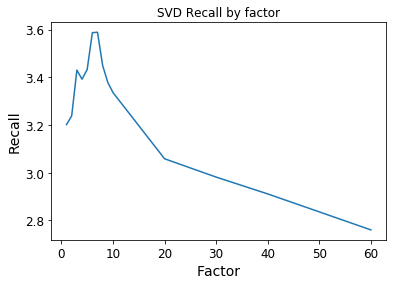

In [56]:
plt.plot(SVD_factor_recalls.keys(),SVD_factor_recalls.values())
plt.ylabel('Recall')
plt.xlabel('Factor')
plt.title('SVD Recall by factor')
plt.show()

In [58]:
SVD_factor_recalls

{1: 3.201741617563456,
 2: 3.238382266089918,
 3: 3.430103246903684,
 4: 3.391921456921977,
 5: 3.432437191328678,
 6: 3.586974503610141,
 7: 3.58879363847095,
 8: 3.449389869137334,
 9: 3.378504800848297,
 10: 3.335975221279354,
 20: 3.0583048627606564,
 30: 2.981471833478248,
 40: 2.910896398215317,
 50: 2.835554989940821,
 60: 2.7599712826333764}